# E-commerce Customers Segmentation

### Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Loading data
try:
    customers = pd.read_excel('E-commerce_data.xlsx', sheet_name='customers')
    genders = pd.read_excel('E-commerce_data.xlsx', sheet_name='genders')
    cities = pd.read_excel('E-commerce_data.xlsx', sheet_name='cities')
    transactions = pd.read_excel('E-commerce_data.xlsx', sheet_name='transactions')
    branches = pd.read_excel('E-commerce_data.xlsx', sheet_name='branches')
    merchants = pd.read_excel('E-commerce_data.xlsx', sheet_name='merchants')

    print("Data loaded successfully!")

except FileNotFoundError:
    print("Error: File not found.")
except Exception as e:
    print("Error:", e)

Data loaded successfully!


In [3]:
# Merging tables
customer_data = customers.merge(genders, on='gender_id', how='left') \
                         .merge(cities, on='city_id', how='left') \
                         .merge(transactions, on='customer_id', how='left') \
                         .merge(branches, on='branch_id', how='left') \
                         .merge(merchants, on='merchant_id', how='left')

### Feature Engineering

In [4]:
# Coupon usage frequency per customer
coupon_usage_freq = customer_data.groupby('customer_id')['transaction_id'].count().reset_index()
coupon_usage_freq.columns = ['customer_id', 'coupon_usage_freq']


In [6]:
print(customer_data.columns)

Index(['customer_id', 'join_date', 'city_id', 'gender_id', 'gender_name',
       'city_name', 'transaction_id', 'transaction_date', 'transaction_status',
       'coupon_name', 'burn_date', 'branch_id', 'merchant_id',
       'merchant_name'],
      dtype='object')


In [7]:
customer_data['coupon_used'] = np.where(customer_data['transaction_status'] == 'used', 1, 0)

In [8]:
# Coupon redemption ratio
customer_data['coupon_redeemed'] = np.where(customer_data['coupon_used'] == 1, 1, 0)
redemption_rate = customer_data.groupby('customer_id')['coupon_redeemed'].mean().reset_index()
redemption_rate.columns = ['customer_id', 'redemption_rate']

In [9]:
# Time to first transaction
customer_data['join_date'] = pd.to_datetime(customer_data['join_date'])
customer_data['transaction_date'] = pd.to_datetime(customer_data['transaction_date'])

# Group by 'customer_id' and calculate time to first transaction
time_to_first_txn = customer_data.groupby('customer_id').apply(
    lambda x: (x['transaction_date'].min() - x['join_date'].min()).days
).reset_index()

time_to_first_txn.columns = ['customer_id', 'time_to_first_txn']


C:\Users\Green\AppData\Local\Temp\ipykernel_8144\3878991506.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_to_first_txn = customer_data.groupby('customer_id').apply(


In [10]:
# Merge the features into a single dataset
customer_features = customers[['customer_id']].merge(coupon_usage_freq, on='customer_id') \
                                              .merge(redemption_rate, on='customer_id') \
                                              .merge(time_to_first_txn, on='customer_id')

###  Exploratory Data Analysis (EDA) and Visualization

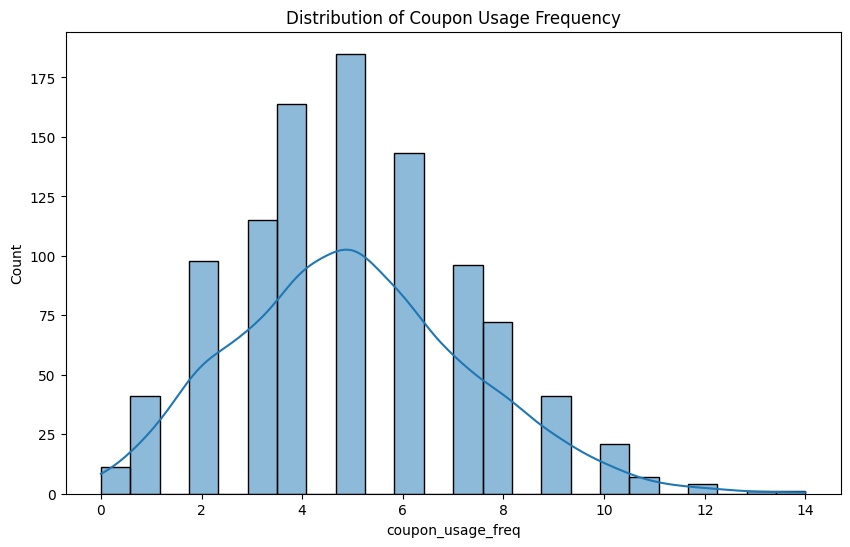

In [11]:
# Visualizing coupon usage frequency
plt.figure(figsize=(10, 6))
sns.histplot(customer_features['coupon_usage_freq'], kde=True)
plt.title('Distribution of Coupon Usage Frequency')
plt.show()

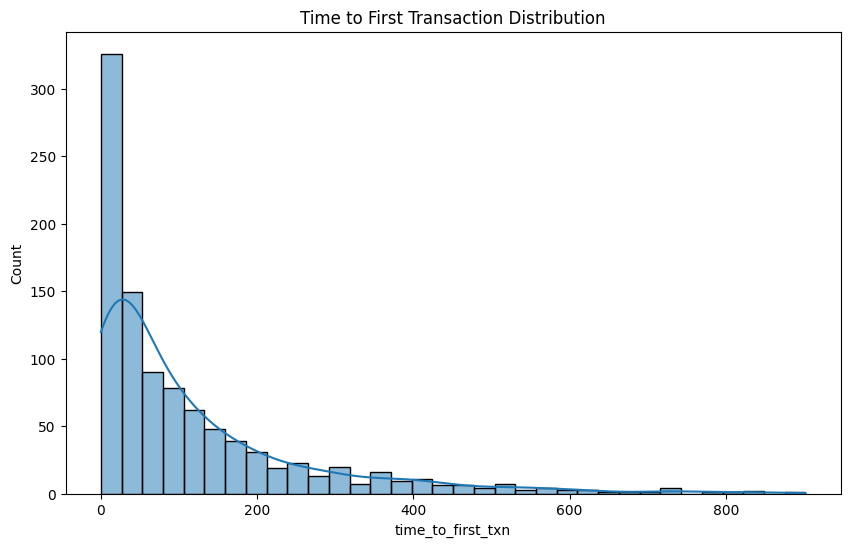

In [12]:
# Visualizing time to first transaction
plt.figure(figsize=(10, 6))
sns.histplot(customer_features['time_to_first_txn'], kde=True)
plt.title('Time to First Transaction Distribution')
plt.show()

### Feature Scaling


In [13]:
# Scaling features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(columns=['customer_id']))


### Training the K-Means Model

#### We can train K-Means and use the elbow method (inertia) and silhouette score to determine the optimal number of clusters.

In [15]:
# Drop rows with NaN values in the scaled features
scaled_features = scaled_features[~np.isnan(scaled_features).any(axis=1)]

In [16]:
# Train K-Means with a range of clusters
inertia = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(scaled_features, kmeans.labels_))

#####  Plot inertia and silhouette score

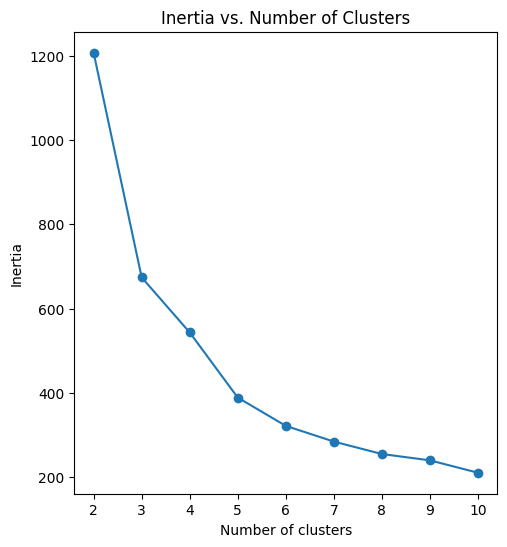

In [17]:

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Inertia vs. Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.show()

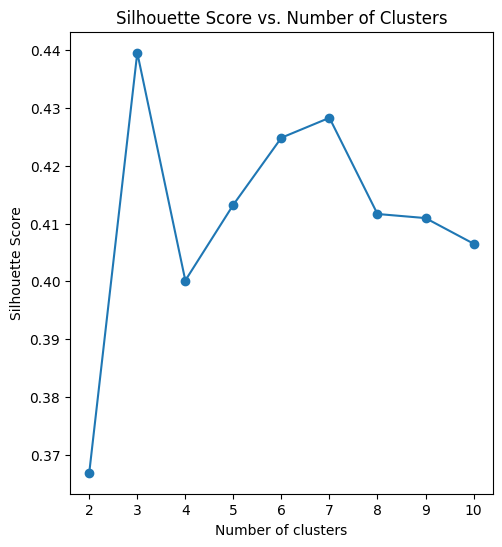

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(k_range, sil_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()

###  Apply Optimal K-Means Model

##### Assume we decide that the optimal number of clusters is 4 based on the silhouette score.

In [22]:
# Check and remove rows with missing values from customer_features and original_features
nan_mask = customer_features.isnull().any(axis=1)

# Apply the same mask to customer_features
customer_features_cleaned = customer_features[~nan_mask].reset_index(drop=True)

# Scale the cleaned features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features_cleaned = scaler.fit_transform(customer_features_cleaned.drop(columns=['customer_id']))

# Fit KMeans with the cleaned dataset
from sklearn.cluster import KMeans

In [21]:
print(customer_data.columns)

Index(['customer_id', 'join_date', 'city_id', 'gender_id', 'gender_name',
       'city_name', 'transaction_id', 'transaction_date', 'transaction_status',
       'coupon_name', 'burn_date', 'branch_id', 'merchant_id', 'merchant_name',
       'coupon_used', 'coupon_redeemed'],
      dtype='object')


In [28]:
# Impute missing values (optional)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
customer_features_cleaned = imputer.fit_transform(customer_features)

# Convert back to DataFrame
customer_features_cleaned = pd.DataFrame(customer_features_cleaned, columns=customer_features.columns)

# Scale the cleaned features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features_cleaned = scaler.fit_transform(customer_features_cleaned.drop(columns=['customer_id']))

# Fit KMeans with the cleaned dataset
from sklearn.cluster import KMeans

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['cluster'] = kmeans.fit_predict(scaled_features_cleaned)

# Verify the results
print(customer_features.shape)

(1000, 5)


         customer_id  coupon_usage_freq  redemption_rate  time_to_first_txn
cluster                                                                    
0         505.737288           8.173729              0.0          58.029661
1         498.626354           4.176895              0.0          51.642726
2         504.337423           3.932515              0.0         272.380368
3         482.978723           2.468085              0.0         575.170213


C:\Users\Green\AppData\Local\Temp\ipykernel_8144\1583253888.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='coupon_usage_freq', data=customer_features, palette='Set2')


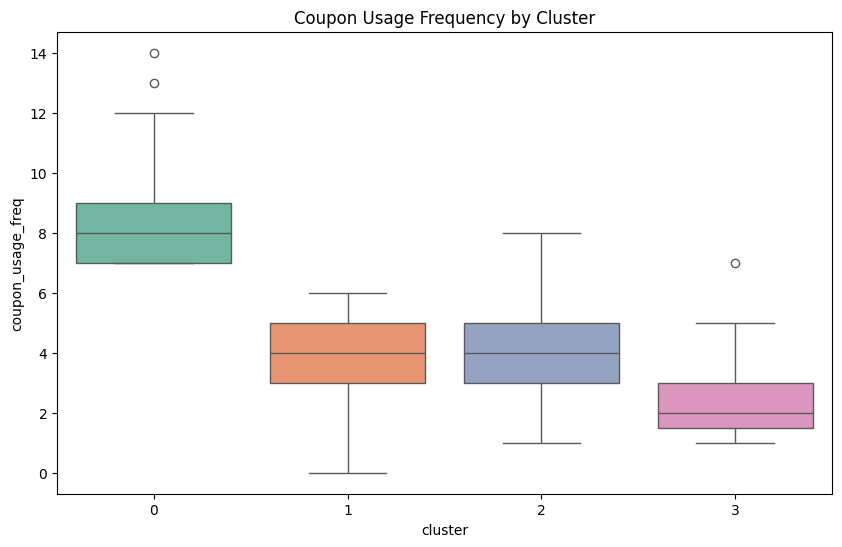

In [32]:
# Group by cluster and analyze the cluster properties
cluster_summary = customer_features.groupby('cluster').mean()
print(cluster_summary)

# Visualize cluster analysis
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='coupon_usage_freq', data=customer_features, palette='Set2')
plt.title('Coupon Usage Frequency by Cluster')
plt.show()


### Coupon Strategy and Recommendations

In [34]:
# Analyze cluster behavior to form recommendations
cluster_behavior = customer_features.groupby('cluster').agg({
    'coupon_usage_freq': ['mean', 'median'],
    'redemption_rate': ['mean', 'median'],
    'time_to_first_txn': ['mean', 'median']
})
print(cluster_behavior)


        coupon_usage_freq        redemption_rate        time_to_first_txn  \
                     mean median            mean median              mean   
cluster                                                                     
0                8.173729    8.0             0.0    0.0         58.029661   
1                4.176895    4.0             0.0    0.0         51.642726   
2                3.932515    4.0             0.0    0.0        272.380368   
3                2.468085    2.0             0.0    0.0        575.170213   

                
        median  
cluster         
0         36.0  
1         37.0  
2        259.0  
3        544.0  


### Project Conclusion
In this project, we successfully:

    Merged and preprocessed the data.
    Performed EDA with visualizations.
    Trained an unsupervised clustering model (K-Means).
    Analyzed clusters and provided actionable insights to improve customer loyalty via tailored coupon strategies.